In [1]:
import iris
import Utils.iris_utils as iris_utils
import pandas as pd
import numpy as np
import os
import logging
import esmvalcore.preprocessor
import glob
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm
import xarray as xr
from xmip.preprocessing import rename_cmip6

In [2]:
#exps = ["ssp370", "historical"]
exps = ["historical"]
#exps = ['ssp245']
#exps = ['ssp126']
dirs = []
var_path = "Amon/tas"
for experiment in exps:
    if experiment == "historical":
        exp_set = "CMIP"
    else:
        exp_set = "ScenarioMIP"
    for x in glob.glob('/badc/cmip6/data/CMIP6/{es}/*/*/{e}/*/{v}/*/latest/'.format(es=exp_set, e=experiment, v=var_path)):
        dirs.append(x)
dirs.reverse()
print(len(dirs))

394


In [3]:
def preprocess(folder, arctic_cut_off=66):
    
    """ makes a df contining global mean and {global except arctic} mean
        temp by year, for the first ensemble member of each model """
    
    outpath = 'int_outputs/temperature_v2/{M}_{Exp}.csv'.format(M=folder.split('/')[7], Exp=folder.split('/')[8])
    #outpath = 'int_outputs/temperature_v3/{M}_{Exp}_{Ens}.csv'.format(
    #                                    M=folder.split('/')[7], Exp=folder.split('/')[8], Ens=folder.split('/')[9])
    if os.path.exists(outpath):
        return
    else:                                                              
        try:
            data = rename_cmip6(xr.open_mfdataset(folder + "*.nc", use_cftime=True))
            winter_mask = data.time.dt.month.isin([12,1,2])
            jan_mask = data.time.dt.month.isin([1]) 
            name = str(folder.split('/')[7] + '_' + folder.split('/')[8] + '_' + folder.split('/')[9])
            
            at_data = data['tas']#.isel(member_id=0)
            
            #at_data = at_data[winter_mask]
            
            years = data.time.dt.year[jan_mask].compute()
            
            # month_length = data.time.dt.days_in_month
            # weights = ( month_length.groupby("time.season") / month_length.groupby("time.season").mean())
            world_annual = (at_data).groupby("time.year").mean(dim="time")
            arctic_annual = world_annual.sel(y=slice(-90,arctic_cut_off))
            
            world_w = world_annual.weighted(weights=np.cos(np.deg2rad(world_annual.y)))
            arctic_w = arctic_annual.weighted(weights=np.cos(np.deg2rad(arctic_annual.y)))
            
            df = pd.DataFrame({'no_arctic_tas':arctic_w.mean(("x","y")).compute().values,
                               'world_tas':world_w.mean(("x","y")).compute().values,
                               'year':years.values})
            
            df.set_index('year',inplace=True)
            df.sort_index(inplace=True)
            df['Model'] = folder.split('/')[7]
            df['Experiment'] = folder.split('/')[8]
            df['Ensemble_member'] = folder.split('/')[9]
            df.to_csv(outpath) 
        except:
            print(name)

In [ ]:
for dir in tqdm(dirs):
    preprocess(dir)

 99%|█████████▉| 158/160 [04:55<00:02,  1.00s/it]

In [2]:
### NB: Hadcrut Analysis has large holes in early years, despite infilling. 
def preprocess_hadcrut(file, arctic_cut_off=66):
    outpath = 'int_outputs/temperature_hadcrut/hadcrut5_tas.csv'

    data = xr.open_mfdataset(Hadcrut_file, use_cftime=True).load()
    data = data.groupby("time.year").mean(dim="time")
    data = data.mean("longitude")
    #print(data)
    new_lat = np.arange(-90, 90, 0.5)
    data = data.interp(latitude=new_lat)
    #print(data)
    
    years = data.year.compute()
                
    arctic_annual = data.sel(latitude=slice(-90,arctic_cut_off))
    world_w = data.weighted(weights=np.cos(np.deg2rad(data.latitude)))
    arctic_w = arctic_annual.weighted(weights=np.cos(np.deg2rad(arctic_annual.latitude)))
    
    
    df = pd.DataFrame({'no_arctic_tas':arctic_w.mean("latitude")['tas_mean'],
                        'world_tas':world_w.mean("latitude")['tas_mean'],
                        'year':years.values})
    
    df.set_index('year',inplace=True)
    df.sort_index(inplace=True)
    df.to_csv(outpath)

Hadcrut_file = 'Inputs/HadCRUT5/Downloaded_29_12_22/HadCRUT.5.0.1.0.analysis.anomalies.ensemble_mean.nc'
#preprocess_hadcrut(Hadcrut_file)

In [3]:
data = xr.open_mfdataset(Hadcrut_file, use_cftime=True).load()
data = data.sel(lat=slice())

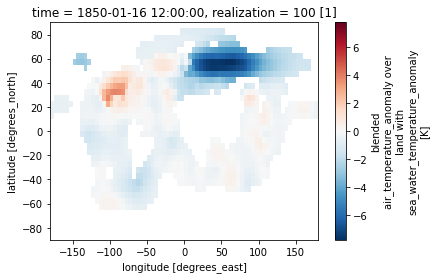

In [6]:
data.isel(time=0)['tas_mean'].plot()

In [ ]:
def preprocess_CW(file, arctic_cut_off=66):
    

In [3]:
def preprocess_multi_ens(folder, arctic_cut_off=66):
    
    """ makes a df contining global mean and {global except arctic} mean
        temp by year, for the first ensemble member of each model """
    
    outpath = 'int_outputs/temperature_multi_ens/{M}_{Exp}_{Ens}.csv'.format(
                M=folder.split('/')[7], Exp=folder.split('/')[8], Ens=folder.split('/')[9])
    
    if os.path.exists(outpath):
        return
    else:                                                              
        try:
            data = rename_cmip6(xr.open_mfdataset(folder + "*.nc", use_cftime=True))
            winter_mask = data.time.dt.month.isin([12,1,2])
            jan_mask = data.time.dt.month.isin([1]) 
            name = str(folder.split('/')[7] + '_' + folder.split('/')[8] + '_' + folder.split('/')[9])
            
            at_data = data['tas']#.isel(member_id=0)
            
            #at_data = at_data[winter_mask]
            
            years = data.time.dt.year[jan_mask].compute()
            
            # month_length = data.time.dt.days_in_month
            # weights = ( month_length.groupby("time.season") / month_length.groupby("time.season").mean())
            world_annual = (at_data).groupby("time.year").mean(dim="time")
            arctic_annual = world_annual.sel(y=slice(-90,arctic_cut_off))
            
            world_w = world_annual.weighted(weights=np.cos(np.deg2rad(world_annual.y)))
            arctic_w = arctic_annual.weighted(weights=np.cos(np.deg2rad(arctic_annual.y)))
            
            df = pd.DataFrame({'no_arctic_tas':arctic_w.mean(("x","y")).compute().values,
                               'world_tas':world_w.mean(("x","y")).compute().values,
                               'year':years.values})
            
            df.set_index('year',inplace=True)
            df.sort_index(inplace=True)
            df['Model'] = folder.split('/')[7]
            df['Experiment'] = folder.split('/')[8]
            df['Ensemble_member'] = folder.split('/')[9]
            df.to_csv(outpath) 
        except:
            print(name)

In [6]:
#dirs.reverse()
dirs[159:]

['/badc/cmip6/data/CMIP6/CMIP/MPI-M/MPI-ESM1-2-HR/historical/r5i1p1f1/Amon/tas/gn/latest/',
 '/badc/cmip6/data/CMIP6/CMIP/MPI-M/MPI-ESM1-2-HR/historical/r4i1p1f1/Amon/tas/gn/latest/',
 '/badc/cmip6/data/CMIP6/CMIP/MPI-M/MPI-ESM1-2-HR/historical/r3i1p1f1/Amon/tas/gn/latest/',
 '/badc/cmip6/data/CMIP6/CMIP/MPI-M/MPI-ESM1-2-HR/historical/r2i1p1f1/Amon/tas/gn/latest/',
 '/badc/cmip6/data/CMIP6/CMIP/MPI-M/MPI-ESM1-2-HR/historical/r1i1p1f1/Amon/tas/gn/latest/',
 '/badc/cmip6/data/CMIP6/CMIP/MPI-M/MPI-ESM1-2-HR/historical/r10i1p1f1/Amon/tas/gn/latest/',
 '/badc/cmip6/data/CMIP6/CMIP/MPI-M/ICON-ESM-LR/historical/r1i1p1f1/Amon/tas/gn/latest/',
 '/badc/cmip6/data/CMIP6/CMIP/MOHC/UKESM1-1-LL/historical/r1i1p1f2/Amon/tas/gn/latest/',
 '/badc/cmip6/data/CMIP6/CMIP/MOHC/UKESM1-0-LL/historical/r9i1p1f2/Amon/tas/gn/latest/',
 '/badc/cmip6/data/CMIP6/CMIP/MOHC/UKESM1-0-LL/historical/r8i1p1f2/Amon/tas/gn/latest/',
 '/badc/cmip6/data/CMIP6/CMIP/MOHC/UKESM1-0-LL/historical/r7i1p1f3/Amon/tas/gn/latest/',
 

In [4]:
for dir in tqdm(dirs):
    preprocess_multi_ens(dir)

 40%|███▉      | 157/394 [15:09<22:52,  5.79s/it]


UnboundLocalError: local variable 'name' referenced before assignment